# Inceptionv2 实现垃圾分类识别
该项目可以帮助实现垃圾分类，类别包括："dianchi", "lajiao", "pingguo", "qiezi", "taoci", "tudou", "xiangjiao", "yandi", "yilaguan", "yinliaoping"。

In [2]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [3]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


## 数据集下载及创建

In [9]:
!git lfs install
!git clone https://modelers.cn/xsir/lajidataset.git

Git LFS initialized.
正克隆到 'lajidataset'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (7/7), 完成.
处理 delta 中: 100% (1/1), 完成.


In [10]:
!unzip -q ./lajidataset/dataset.zip -d ./lajidataset

In [4]:
import os

import mindspore as ms
from mindspore.dataset import ImageFolderDataset
import mindspore.dataset.vision as transforms


data_path = './lajidataset/dataset/'
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

dataset_train = ImageFolderDataset(os.path.join(data_path, "train"), shuffle=True)

trans_train = [
    transforms.RandomCropDecodeResize(size=224,
                                      scale=(0.08, 1.0),
                                      ratio=(0.75, 1.333)),
    transforms.RandomHorizontalFlip(prob=0.5),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_train = dataset_train.map(operations=trans_train, input_columns=["image"])
dataset_train = dataset_train.batch(batch_size=16, drop_remainder=True)

### Inception V2网络结构


In [5]:
"""inceptionv2 net"""
import mindspore.nn as nn
import mindspore.ops as op
from mindspore.common.initializer import TruncatedNormal
from mindspore.ops import operations as P


def weight_variable(stddev):
    """Weight variable."""
    return TruncatedNormal(stddev)


class Conv2dBlock(nn.Cell):
    """Conv2dBlock"""

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0,
                 pad_mode="same", is_variable=True):
        super(Conv2dBlock, self).__init__()
        self.is_variable = is_variable
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                                padding=padding, pad_mode=pad_mode, weight_init="XavierUniform")
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.9997)
        self.relu = nn.ReLU()

    def construct(self, x):
        """construct"""
        x = self.conv_1(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class depthwise_separable_conv(nn.Cell):
    "Depthwise conv + Pointwise conv"

    def __init__(self, in_channels, out_channels, kernel_size=1,
                 stride=1, padding=0, pad_mode="same"):
        super(depthwise_separable_conv, self).__init__()
        self.is_use_pointwise = out_channels
        if out_channels is not None:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   stride, padding=padding, pad_mode=pad_mode, group=in_channels,
                                   weight_init="XavierUniform")
            self.conv2 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=1, padding=0, weight_init="XavierUniform")
        else:
            self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, group=in_channels,
                                   padding=padding, pad_mode=pad_mode,
                                   weight_init="XavierUniform")
        self.Relu = nn.ReLU()

    def construct(self, x):
        """construct"""
        if self.is_use_pointwise is not None:
            x = self.conv1(x)
            x = self.conv2(x)
        else:
            x = self.conv1(x)
        x = self.bn(x)
        x = self.Relu(x)
        return x


class Inception(nn.Cell):
    """Inception Block"""

    def __init__(self, in_channels, n1x1, n3x3red_a, n3x3, n3x3red_b, n3x3red_b_2, pool_planes):
        super(Inception, self).__init__()
        self.b1 = Conv2dBlock(in_channels, n1x1, kernel_size=1, is_variable=False)
        self.b2 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red_a, kernel_size=1),
                                     Conv2dBlock(n3x3red_a, n3x3, kernel_size=3, padding=0, is_variable=False)])
        self.b3 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red_b, kernel_size=1),
                                     Conv2dBlock(n3x3red_b, n3x3red_b_2, kernel_size=3, padding=0, is_variable=False),
                                     Conv2dBlock(n3x3red_b_2, n3x3red_b_2, kernel_size=3, padding=0,
                                                 is_variable=False)])
        self.avgpool_op = op.AvgPool(pad_mode="SAME", kernel_size=3, strides=1)
        self.b4 = Conv2dBlock(in_channels, pool_planes, kernel_size=1)
        self.concat = op.Concat(axis=1)

    def construct(self, x):
        """construct"""
        branch1 = self.b1(x)
        branch2 = self.b2(x)
        branch3 = self.b3(x)
        cell = self.avgpool_op(x)
        branch4 = self.b4(cell)
        return self.concat((branch1, branch2, branch3, branch4))


class Inception_2(nn.Cell):
    """Inception_2 Block"""

    def __init__(self, in_channels, n3x3red_a, n3x3, n3x3red_b, n3x3red_b_2):
        super(Inception_2, self).__init__()
        self.b1 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red_a, kernel_size=1),
                                     Conv2dBlock(n3x3red_a, n3x3, kernel_size=3,
                                                 stride=2, padding=0, is_variable=False)])
        self.b2 = nn.SequentialCell([Conv2dBlock(in_channels, n3x3red_b, kernel_size=1),
                                     Conv2dBlock(n3x3red_b, n3x3red_b_2, kernel_size=3, padding=0, is_variable=False),
                                     Conv2dBlock(n3x3red_b_2, n3x3red_b_2, kernel_size=3,
                                                 padding=0, stride=2, is_variable=False)])
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="SAME")
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        """construct"""
        branch1 = self.b1(x)
        branch2 = self.b2(x)
        branch3 = self.maxpool(x)
        return self.concat((branch1, branch2, branch3))


class Logits(nn.Cell):
    """Module for Loss"""

    def __init__(self, num_classes=10, dropout_keep_prob=0.8):
        super(Logits, self).__init__()
        self.avg_pool = nn.AvgPool2d(7, pad_mode='valid')
        self.dropout = nn.Dropout(p=1 - dropout_keep_prob)
        self.flatten = P.Flatten()
        self.fc = nn.Dense(1024, num_classes)

    def construct(self, x):
        """construct"""
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


class inception_v2_base(nn.Cell):
    """Detail for net"""

    def __init__(self, num_classes=10, input_channels=3, use_separable_conv=False,
                 dropout_keep_prob=0.8, include_top=True):
        super(inception_v2_base, self).__init__()
        self.feature_map_channels = {'Conv2d_1a_7x7': 64, 'MaxPool_2a_3x3': 64,
                                     'Conv2d_2b_1x1': 64, 'Conv2d_2c_3x3': 192,
                                     'MaxPool_3a_3x3': 192, 'Mixed_3b': 256,
                                     'Mixed_3c': 320, 'Mixed_4a': 576, 'Mixed_4b': 576,
                                     'Mixed_4c': 576, 'Mixed_4d': 576, 'Mixed_4e': 576,
                                     'Mixed_5a': 1024, 'Mixed_5b': 1024, 'Mixed_5c': 1024}

        if use_separable_conv:
            self.Conv2d_1a_7x7 = depthwise_separable_conv(input_channels, 64,
                                                          kernel_size=7, stride=2, padding=0)
        else:
            self.Conv2d_1a_7x7 = Conv2dBlock(input_channels, 64, kernel_size=7, stride=2)
        self.MaxPool_2a_3x3 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        self.Conv2d_2b_1x1 = Conv2dBlock(64, 64, kernel_size=1)
        self.Conv2d_2c_3x3 = Conv2dBlock(64, 192, kernel_size=3, padding=0)
        self.MaxPool_3a_3x3 = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode="same")
        self.Mixed_3b = Inception(192, 64, 64, 64, 64, 96, 32)
        self.Mixed_3c = Inception(256, 64, 64, 96, 64, 96, 64)
        self.Mixed_4a = Inception_2(320, 128, 160, 64, 96)
        self.Mixed_4b = Inception(576, 224, 64, 96, 96, 128, 128)
        self.Mixed_4c = Inception(576, 192, 96, 128, 96, 128, 128)
        self.Mixed_4d = Inception(576, 160, 128, 160, 128, 160, 96)
        self.Mixed_4e = Inception(576, 96, 128, 192, 160, 192, 96)
        self.Mixed_5a = Inception_2(576, 128, 192, 192, 256)
        self.Mixed_5b = Inception(1024, 352, 192, 320, 160, 224, 128)
        self.Mixed_5c = Inception(1024, 352, 192, 320, 192, 224, 128)
        self.include_top = include_top
        if self.include_top:
            self.logits = Logits(num_classes, dropout_keep_prob)

    def construct(self, inputs):
        """inceptionv2 construct"""
        end_points = {}
        temp_point = 'Conv2d_1a_7x7'
        net = self.Conv2d_1a_7x7(inputs)
        end_points[temp_point] = net
        temp_point = 'MaxPool_2a_3x3'
        net = self.MaxPool_2a_3x3(net)
        end_points[temp_point] = net
        temp_point = 'Conv2d_2b_1x1'
        net = self.Conv2d_2b_1x1(net)
        end_points[temp_point] = net
        temp_point = 'Conv2d_2c_3x3'
        net = self.Conv2d_2c_3x3(net)
        end_points[temp_point] = net
        temp_point = 'MaxPool_3a_3x3'
        net = self.MaxPool_3a_3x3(net)
        end_points[temp_point] = net
        temp_point = 'Mixed_3b'
        net = self.Mixed_3b(net)
        end_points[temp_point] = net
        temp_point = 'Mixed_3c'
        net = self.Mixed_3c(net)
        end_points[temp_point] = net
        # 28 x 28 x 320
        temp_point = 'Mixed_4a'
        net = self.Mixed_4a(net)
        end_points[temp_point] = net
        # 14 x 14 x 576
        temp_point = 'Mixed_4b'
        net = self.Mixed_4b(net)
        end_points[temp_point] = net
        # 14 x 14 x 576
        temp_point = 'Mixed_4c'
        net = self.Mixed_4c(net)
        end_points[temp_point] = net
        # 14 x 14 x 576
        temp_point = 'Mixed_4d'
        net = self.Mixed_4d(net)
        end_points[temp_point] = net
        # 14 x 14 x 576
        temp_point = 'Mixed_4e'
        net = self.Mixed_4e(net)
        end_points[temp_point] = net
        # 14 x 14 x 576
        temp_point = 'Mixed_5a'
        net = self.Mixed_5a(net)
        end_points[temp_point] = net
        temp_point = 'Mixed_5b'
        net = self.Mixed_5b(net)
        end_points[temp_point] = net
        temp_point = 'Mixed_5c'
        net = self.Mixed_5c(net)
        end_points[temp_point] = net
        if not self.include_top:
            return net
        logits = self.logits(net)
        return logits


## 模型训练与推理

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等。

完整训练该模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [6]:
# 定义网络
network = inception_v2_base(num_classes=10, dropout_keep_prob=0.8)

In [7]:
%%time
from mindspore.nn import LossBase
from mindspore.train import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore import train
from mindspore import ops
# define super parameter
epoch_size = 20
momentum = 0.9
resize = 224
step_size = dataset_train.get_dataset_size()
num_classes =10

# define learning rate
lr = nn.cosine_decay_lr(min_lr=float(0),
                        max_lr=0.00005,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=10)

# define optimizer
network_opt = nn.Adam(network.trainable_params(), lr, momentum)


# define loss function
class CrossEntropySmooth(LossBase):
    """CrossEntropy."""

    def __init__(self, sparse=True, reduction='mean', smooth_factor=0., num_classes=1000):
        super(CrossEntropySmooth, self).__init__()
        self.onehot = ops.OneHot()
        self.sparse = sparse
        self.on_value = ms.Tensor(1.0 - smooth_factor, ms.float32)
        self.off_value = ms.Tensor(1.0 * smooth_factor / (num_classes - 1), ms.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits(reduction=reduction)

    def construct(self, logit, label):
        if self.sparse:
            label = self.onehot(label, ops.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, label)
        return loss


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# set checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=5)
ckpt_callback = ModelCheckpoint(prefix='incetion_v2', directory='./inceptionv2', config=ckpt_config)

# initialize model
# "Ascend + mixed precision" can improve performance
ascend_target = (ms.get_context("device_target") == "Ascend")
if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O0")

# train model
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(125), TimeMonitor(125)],
            dataset_sink_mode=False,)

/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [192, 192], [16, 63], [16, 63]] to [[16, 31], [192, 192], [16, 63], (16, 63)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [256, 256], [16, 63], [16, 63]] to [[16, 31], [256, 256], [16, 63], (16, 63)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [576, 576], [4, 15], [4, 15]] to [[16, 31], [576, 576], [4, 15], (4, 15)].
  warnings.warn(to_print)
/usr/local/Ascend/ascend-toolkit/8.0.0/opp/built-in/op_impl/ai_core/tbe/impl/util/util_conv2d_dynamic.py:130: UserWarning: conv2d fmap ori_range changed from [[16, 31], [1024, 1024],

....Train epoch time: 66899.880 ms, per step time: 1262.262 ms
Train epoch time: 12761.316 ms, per step time: 240.780 ms
epoch: 3 step: 19, loss is 0.9946805
Train epoch time: 12444.498 ms, per step time: 234.802 ms
Train epoch time: 12824.371 ms, per step time: 241.969 ms
epoch: 5 step: 38, loss is 0.996889
Train epoch time: 12960.146 ms, per step time: 244.531 ms
Train epoch time: 12242.930 ms, per step time: 230.999 ms
Train epoch time: 12370.578 ms, per step time: 233.407 ms
epoch: 8 step: 4, loss is 0.633258
Train epoch time: 12622.883 ms, per step time: 238.168 ms
Train epoch time: 12397.312 ms, per step time: 233.912 ms
epoch: 10 step: 23, loss is 0.9119402
Train epoch time: 12243.910 ms, per step time: 231.017 ms
Train epoch time: 12356.061 ms, per step time: 233.133 ms
epoch: 12 step: 42, loss is 0.71608263
Train epoch time: 12184.530 ms, per step time: 229.897 ms
Train epoch time: 12341.416 ms, per step time: 232.857 ms
Train epoch time: 12213.910 ms, per step time: 230.451 m

### 模型验证

模型验证过程主要应用了ImageFolderDataset，CrossEntropySmooth和Model等接口。

ImageFolderDataset主要用于读取数据集。

CrossEntropySmooth是损失函数实例化接口。

Model主要用于编译模型。

与训练过程相似，首先进行数据增强，然后定义ViT网络结构，加载预训练模型参数。随后设置损失函数，评价指标等，编译模型后进行验证。本案例采用了业界通用的评价标准Top_1_Accuracy评价指标来评价模型表现。

In [8]:
dataset_val = ImageFolderDataset(os.path.join(data_path, "val"), shuffle=True)

trans_val = [
    transforms.Decode(),
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_val = dataset_val.map(operations=trans_val, input_columns=["image"])
dataset_val = dataset_val.batch(batch_size=16, drop_remainder=True)


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# define metric
eval_metrics = {'Top_1_Accuracy': train.Top1CategoricalAccuracy()}

if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O0")

# evaluate model
result = model.eval(dataset_val)
print(result)

.{'Top_1_Accuracy': 0.10416666666666667}


从结果可以看出，由于我们加载了预训练模型参数，模型的Top_1_Accuracy和Top_5_Accuracy达到了很高的水平，实际项目中也可以以此准确率为标准。如果未使用预训练模型参数，则需要更多的epoch来训练。

### 模型推理

在进行模型推理之前，首先要定义一个对推理图片进行数据预处理的方法。该方法可以对我们的推理图片进行resize和normalize处理，这样才能与我们训练时的输入数据匹配。

本案例采用了一张Doberman的图片作为推理图片来测试模型表现，期望模型可以给出正确的预测结果。

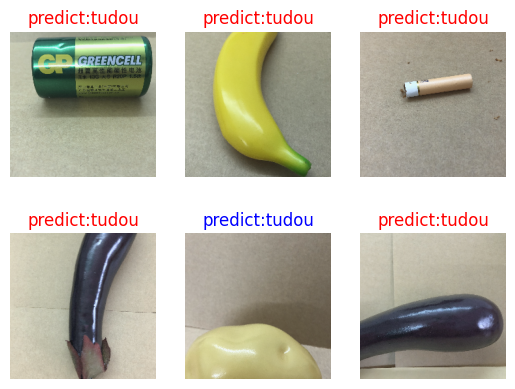

In [20]:
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
output = network(data['image'])
pred = np.argmax(output.asnumpy(), axis=1)

# 图像分类
classes = ["dianchi", "lajiao", "pingguo", "qiezi", "taoci", "tudou", 
           "xiangjiao", "yandi", "yilaguan", "yinliaoping"]

# 显示图像及图像的预测值
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
    plt.title('predict:{}'.format(classes[pred[i]]), color=color)
    picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    picture_show = std * picture_show + mean
    picture_show = np.clip(picture_show, 0, 1)
    plt.imshow(picture_show)
    plt.axis('off')

plt.show()